# Replay based Class Incremental Learning (CIL) with PyTorch

This notebook covers a simplified implementation of class incremental learning (CIL) using replay-based techniques. The goal of CIL is to learn a model that can incrementally learn new classes without forgetting the previously learned classes. In this notebook, we will use a replay-based technique to store and replay the data from the previous classes to prevent forgetting.

To do this, we will use the following steps:
Train base model on the first set of two classes e.g. 0 and 1 for 100 epochs utilising Stochastic Gradient Descent (SGD) with a learning rate of 0.01.
After training our base model, we will then store a subset of our data from the first two classes in a replay buffer, let $R_i$ be the replay buffer for class $i$ and $D_i$ be the training data for class $i$ up to that training step inclusive of all previous classes.

We denote: $R_i \subseteq D_i$

And: $D_i = \cup_{x = 0}^{i}d_x$

Where $d_x$ is the data for class $x$.

i.e. the replay buffer will only contain a variant subset of the data from the previous classes as opposed to all the data of that class which
we can change to determine the effect of the replay buffer size on the model's performance.

From this point onwards, we will incrementally train our model utilising Class-Incremental Learning (CIL) by training on the class and replaying the data from the previous classes.

This model will utilise a standard implementation of a ResNet18 CNN model with a single fully connected layer at the end to classify the images. It will also be trained on the CIFAR-10 dataset, which contains 60,000 32x32 colour images in 10 classes, with 6,000 images per class.

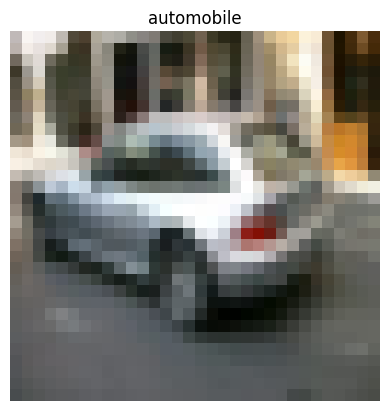

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes 
from torch.utils.data import DataLoader
import random

# Path to the dataset
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Define custom ResNet18 model for CIFAR10

In this case we chance the convolution kernel to 3x3 and the stride to 1 for the first layer. We will also change the number of classes on the final softmax layer to 10 to match the CIFAR10 dataset.

In [2]:
class ResNet18CIFAR(torch.nn.Module):
    def __init__(self):
        super(ResNet18CIFAR, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # change the first layer to accept 32x32 images with 3 channels rather than 224x224 images
        # check the size of the input layer
        self.resnet.conv1 = torch.nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.resnet.bn1 = torch.nn.BatchNorm2d(128)
        # change number of blocks per layer
        self.resnet.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128)
        )
        self.resnet.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(256)
        )
        self.resnet.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(512)
        )
        self.resnet.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024)
        )
        # change input layer to accept 32x32 images by utilising smaller convolutional kernel
        self.resnet.fc = torch.nn.Linear(1024, 5)
        # start with 5 classes and add more as needed
        self.resnet.maxpool = torch.nn.Identity()
        # maxpool worsens performance and is unnecessary for small image sizes
        

    def forward(self, x):
        return self.resnet(x)
    
model = ResNet18CIFAR()
model.eval

Using cache found in /dcs/21/u2145461/.cache/torch/hub/pytorch_vision_v0.10.0
/local/java/python-ml/22-12-21-python3.9/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/java/python-ml/22-12-21-python3.9/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<bound method Module.eval of ResNet18CIFAR(
  (resnet): ResNet(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), strid

### Data Load and Preprocessing into separate class datasets

Utilise the CIFAR-10 dataset alongside a prebuilt dataloader to load the data into separate class datasets.
(Krishi's code)

In [3]:
train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



# The Algorithm

Train initial model on the first two classes.

For each class $i$ in the dataset:

1. Train the model on the current class $i$ and replay the data from the previous classes.

2. Store a subset of the data from the current class $i$ in the replay buffer $R_i$.

3. Evaluate the model on the test set.

4. Increment the number of classes seen.

5. Repeat steps 1-4 for each class in the dataset.

Note: the size of the replay buffer is a hyperparameter that can be tuned to determine the effect of the replay buffer size on the model's performance.

The following hyperparameters will be used in this notebook:

- Epochs: 100 (per class)
- Learning rate: 0.00005
- Momentum: 0.9 (if using SGD)
- Batch size: 512
- Replay buffer size: Variant (e.g. 1000, 2000, 3000, 4000, 5000 per class)

### References

1. [Continual Learning with Deep Architectures: A Review](https://arxiv.org/abs/1907.04471)

2. [RECALL Replay Based Continual Learning in Semantic Segmentation](https://openaccess.thecvf.com/content/ICCV2021/papers/Maracani_RECALL_Replay-Based_Continual_Learning_in_Semantic_Segmentation_ICCV_2021_paper.pdf)

In [4]:
def calculate_accuracy(model, accuracies, input_data, input_labels):
        # calculate accuracy
        correct = 0
        total = len(input_data)
        batch = 100
        for j in range(0, len(input_data), batch):
            image = input_data[j:j+batch]
            labels = input_labels[j:j+batch]
            outputs = model(image)
            # get the index of the highest value
            _, predicted = torch.max(outputs.data, 1)
            # add the number of correct predictions to the total
            correct += (predicted == labels).sum().item()
                
        accuracy_string = "Accuracy: "
        accuracies.append(correct/total * 100)
        accuracy_string += (f"{correct/total * 100:.2f}% ")

        return accuracy_string, accuracies

In [5]:
# free up gpu memory
torch.cuda.empty_cache()
memory = torch.cuda.memory_allocated()
print(f"Memory allocated: {memory/1e9} GB")

replay_memory = {cls: [] for cls in CLASSES}
accuracies = []
learning_rate = 0.01
momentum = 0.9
batch_size = 1000
epochs = 100
loss_function = torch.nn.CrossEntropyLoss()
# output is softmax gaussian probability distribution, so cross entropy loss is appropriate
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

# firstly, train on 5 classes utilising Adam
current_train_data, current_train_labels = split_into_classes(train_data, train_labels, ['airplane', 'automobile', 'bird', 'cat', 'deer'])

# convert to tensors
current_train_data = torch.tensor(current_train_data).float()
current_train_labels = torch.tensor(current_train_labels)

current_test_data, current_test_labels = split_into_classes(test_data, test_labels, ['airplane', 'automobile', 'bird', 'cat', 'deer'])

current_test_data = torch.tensor(current_test_data).float()
current_test_labels = torch.tensor(current_test_labels)

if torch.cuda.is_available():
    model = model.cuda()
    current_train_data = current_train_data.cuda()
    current_train_labels = current_train_labels.cuda()
    current_test_data = current_test_data.cuda()
    current_test_labels = current_test_labels.cuda()

# we have figured out CUDA for jupyter notebooks :)
for i in range(epochs):
    accuracy_string, accuracies = calculate_accuracy(model, accuracies, current_train_data, current_train_labels)
    # calculate accuracy
    
    for j in range(0, len(current_train_data), batch_size):
        optimiser.zero_grad()
        images = current_train_data[j:j+batch_size]
        labels = current_train_labels[j:j+batch_size]
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        if j == 0:
            losses.append(loss.item())
        loss.backward()
        optimiser.step()
    print(f"Epoch {i+1}/{epochs}, " + accuracy_string + f"Loss: {losses[len(losses)-1]}")
    # accuracy greater than 80% we stop training
    if accuracies[len(accuracies)-1] > 70:
        break
    
accuracy_string, _ = calculate_accuracy(model, accuracies, current_test_data, current_test_labels)
# remove last element from accuracies
accuracies.pop()


Memory allocated: 0.0 GB
Epoch 1/100, Accuracy: 17.00% Loss: 1.633905291557312
Epoch 2/100, Accuracy: 57.84% Loss: 1.0140568017959595
Epoch 3/100, Accuracy: 63.50% Loss: 0.8860978484153748
Epoch 4/100, Accuracy: 63.97% Loss: 0.8546938300132751
Epoch 5/100, Accuracy: 67.06% Loss: 0.8041112422943115
Epoch 6/100, Accuracy: 69.30% Loss: 0.7441363334655762
Epoch 7/100, Accuracy: 68.43% Loss: 0.7397769689559937
Epoch 8/100, Accuracy: 72.80% Loss: 0.6486735343933105


68.26

### Initial Results for five classes

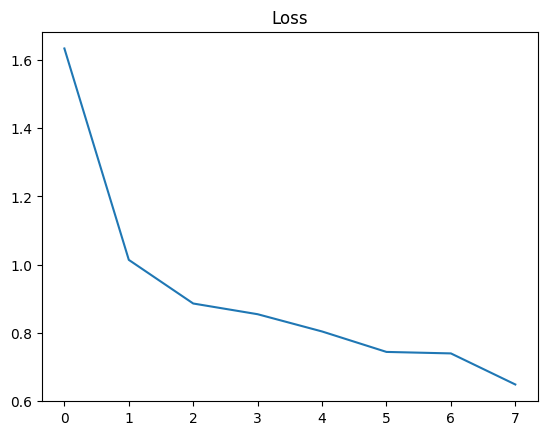

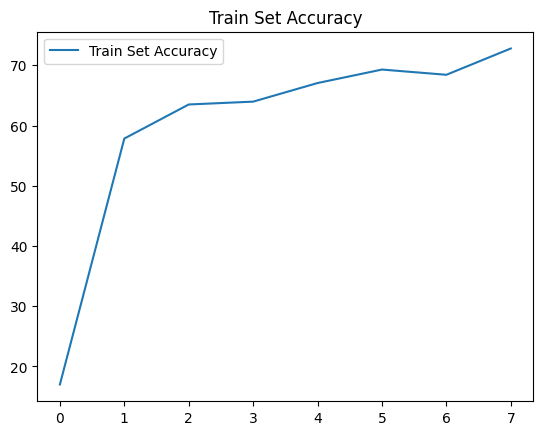

In [6]:
# plot the loss and accuracy
# fix axes labels
plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies

plt.plot(accuracies, label='Train Set Accuracy')
plt.title('Train Set Accuracy')
plt.legend()
plt.show()

In [7]:
def calculate_accuracy_class(model, accuracies, data, labels):
        # calculate accuracy
        correct = [0] * 10
        total = len(data)/10
        batch_size = 1000
        with torch.no_grad():
            for j in range(0, len(data), batch_size):
                image = data[j:j+batch_size]
                label = labels[j:j+batch_size]
                outputs = model(image)
                _, predicted = torch.max(outputs.data, 1)
                for i in range(10):  
                    correct[i] += (predicted[label == i] == label[label == i]).sum().item()
        
        j = 0
        accuracy_string = "Accuracy: "
        for classes in accuracies:
             accuracies[classes].append(correct[j]/total * 100)
             accuracy_string += (f"" + classes + f": {correct[j]/total * 100:.2f}%, ")
             j += 1

        return accuracy_string, accuracies

# Train on next 5 classes

In [ ]:
from cifar import split_into_classes

MEMORY_BUFFER = 15000

replay_memory_data, replay_memory_labels = split_into_classes(train_data, train_labels, ['airplane', 'automobile', 'bird', 'cat', 'deer'])
replay_memory_data = replay_memory_data[:MEMORY_BUFFER]
replay_memory_labels = replay_memory_labels[:MEMORY_BUFFER]
old_weights = model.resnet.fc.weight.data.clone()
old_biases = model.resnet.fc.bias.data.clone()
new_10_output_layer = torch.nn.Linear(1024, 10)
print(new_10_output_layer.weight.data)
print(old_weights)
new_10_output_layer.weight.data[:5] = old_weights
new_10_output_layer.bias.data[:5] = old_biases
model.resnet.fc = new_10_output_layer

# free up gpu memory
torch.cuda.empty_cache()
memory = torch.cuda.memory_allocated()
print(f"Memory allocated: {memory/1e9} GB")

accuracies_class = {cls: [] for cls in CLASSES}
accuracies_class_test = {cls: [] for cls in CLASSES}

accuracies = []
learning_rate = 0.01
momentum = 0.9
batch_size = 1000
epochs = 100
loss_function = torch.nn.CrossEntropyLoss()
# output is softmax gaussian probability distribution, so cross entropy loss is appropriate
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

# firstly, train on 5 classes utilising SGD
current_train_data, current_train_labels = split_into_classes(train_data, train_labels, ['dog', 'frog', 'horse', 'ship', 'truck'])

current_train_data = list(replay_memory_data) + list(current_train_data)
current_train_labels = list(replay_memory_labels) + list(current_train_labels)

# shuffle the data
shuffled = list(zip(current_train_data, current_train_labels))
random.shuffle(shuffled)
current_train_data, current_train_labels = zip(*shuffled)

current_test_data, current_test_labels = split_into_classes(test_data, test_labels, CLASSES)

# convert to tensors
current_train_data = torch.tensor(current_train_data).float()
current_train_labels = torch.tensor(current_train_labels)

train_data = torch.tensor(train_data).float()
train_labels = torch.tensor(train_labels)
current_test_data = torch.tensor(current_test_data).float()
current_test_labels = torch.tensor(current_test_labels)

if torch.cuda.is_available():
    model = model.cuda()
    current_train_data = current_train_data.cuda()
    current_train_labels = current_train_labels.cuda()
    current_test_data = current_test_data.cuda()
    current_test_labels = current_test_labels.cuda()

# we have figured out CUDA for jupyter notebooks :)
for i in range(epochs):
    accuracy_string, accuracies = calculate_accuracy(model, accuracies, current_train_data, current_train_labels)
    _, accuracies_class = calculate_accuracy_class(model, accuracies_class, current_train_data, current_train_labels)
    # calculate accuracy
    
    for j in range(0, len(current_train_data), batch_size):
        optimiser.zero_grad()
        images = current_train_data[j:j+batch_size]
        labels = current_train_labels[j:j+batch_size]
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        if j == 0:
            losses.append(loss.item())
        loss.backward()
        optimiser.step()
    print(f"Epoch {i+1}/{epochs}, " + accuracy_string + f"Loss: {losses[len(losses)-1]}")
    # accuracy greater than 80% we stop training
    if accuracies[len(accuracies)-1] > 70:
        break
    
_ , accuracies_class_test = calculate_accuracy_class(model, accuracies_class_test, current_test_data, current_test_labels)
accuracy_string, _ = calculate_accuracy(model, accuracies, current_test_data, current_test_labels)

# remove last element from accuracies
accuracies.pop()

# print all classes in accuracies_class_test
for cls in CLASSES:
    print(f"Test accuracy for {cls}: {accuracies_class_test[cls]}")


tensor([[ 0.0437,  0.0395,  0.0339,  ..., -0.0395, -0.0049,  0.0170],
        [ 0.0416, -0.0075, -0.0218,  ..., -0.0086,  0.0312, -0.0362],
        [ 0.0216, -0.0339,  0.0419,  ...,  0.0026,  0.0175, -0.0315],
        ...,
        [ 0.0315, -0.0353,  0.0264,  ..., -0.0266,  0.0004,  0.0151],
        [-0.0261, -0.0211, -0.0379,  ...,  0.0264, -0.0189,  0.0272],
        [ 0.0333, -0.0207,  0.0128,  ...,  0.0361, -0.0178, -0.0413]])
tensor([[-1.4741e-04,  8.0841e-03,  2.7169e-02,  ..., -1.3968e-02,
          1.5027e-02,  1.0934e-02],
        [ 7.2560e-03,  1.0760e-02, -4.9471e-03,  ..., -3.1943e-02,
         -1.2594e-02, -4.0989e-03],
        [ 1.7364e-06,  2.9075e-03,  3.1930e-02,  ...,  2.1435e-02,
         -1.9865e-02,  2.2318e-02],
        [ 3.0543e-02, -3.2931e-02,  2.7480e-02,  ..., -1.6533e-03,
          1.9320e-02,  3.4188e-02],
        [-2.1773e-03,  2.5954e-02,  3.6262e-03,  ..., -7.5786e-03,
         -2.3127e-02, -2.4696e-02]], device='cuda:0')


RuntimeError: The expanded size of the tensor (512) must match the existing size (1024) at non-singleton dimension 1.  Target sizes: [5, 512].  Tensor sizes: [5, 1024]

In [ ]:
# plot the loss and accuracy
# fix axes labels
plt.plot(losses)
plt.title('Loss')
plt.show()

for i in range(len(accuracies)):
    print(f"Accuracy at {i} : {accuracies[i]}")

for cls in CLASSES:
    plt.plot(accuracies_class[cls], label=f'{cls}')

plt.title('Train Set Accuracy over Epochs')
plt.legend()
plt.show()

# plot the test set accuracy as a bar chart
plt.bar(CLASSES, [accuracies_class_test[cls][0] for cls in CLASSES])
plt.title('Test Set Accuracy for Each Class')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.show()
for cls in CLASSES:
    print(f"Test accuracy for {cls}: {accuracies_class_test[cls]}")
    
print(f"Test accuracy on all 10 classes: {accuracy_string}")
    